H is the same
H is the same
H is the same


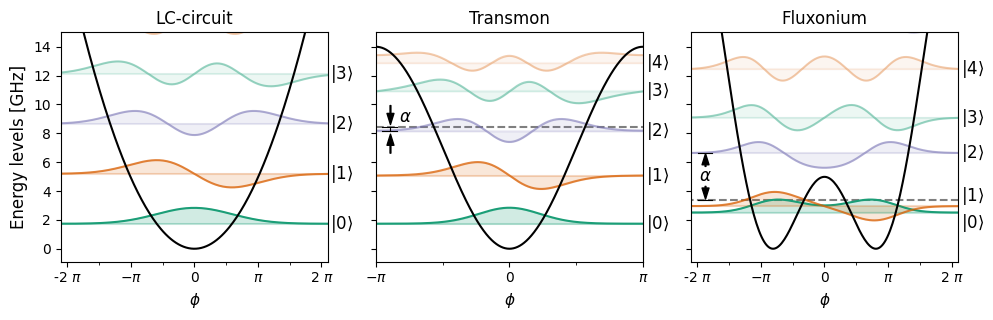

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.special import eval_hermite
from math import factorial

# Parameters
phi_max = 10 * np.pi  # phase basis cutoff
N = 1000  # number of grid points
phi = np.linspace(-phi_max, phi_max, N)
dphi = phi[1] - phi[0]

def get_n2(N,max, periodic=False):
    arr_fund = [1/(dphi**2),-2/(dphi**2),1/(dphi**2)]
    arr = np.zeros((N,N))
    for i in range(N):
        for j in range(i-2,N):
            if i == j:
                arr[i][j] = arr_fund[1]
            elif i-j == 1 or i-j == -1:
                arr[i][j] = arr_fund[0]
            if j > i+1:
                break
    if periodic:
        arr[0][-1] = arr_fund[2]
        arr[-1][0] = arr_fund[2]
    return arr


energies = {
    "LC circuit": {
        "EL": 1.0,  # inductive energy (in units of charging energy)
        "EC": 1.5,  # charging energy (in units of charging energy)
    },
    "Transmon": {
        "EJ": 7.0,  # Josephson energy (in units of charging energy)
        "EC": 23.0,  # charging energy (in units of charging energy)
    },
    "Fluxonium": {
        "EJ": 4.5,  # Josephson energy (in units of charging energy)
        "EL": 1.0,  # inductive energy (in units of charging energy)
        "EC": 1.0,  # charging energy (in units of charging energy)
    },
}

# Kinetic energy

Ec = energies["Transmon"]["EC"]
T_trans = -4*Ec*get_n2(N, np.pi, periodic=True)
phi_trans = np.linspace(-np.pi, np.pi, N)
Ec = energies["LC circuit"]["EC"]
T_LC = -4*Ec*get_n2(N, phi_max, periodic=False)
Ec = energies["Fluxonium"]["EC"]
T_flux = -4*Ec*get_n2(N, phi_max, periodic=False)

# LC circuit — simple harmonic oscillator
V_LC = np.diag(0.5 * phi**2)

# Transmon — cosine potential
EJ = energies["Transmon"]["EJ"]
V_Transmon = np.diag(-EJ * np.cos(phi_trans))

# Fluxonium — cosine + parabolic offset (with external flux phi_ext=0)
EL = energies["Fluxonium"]["EL"]
EJ = energies["Fluxonium"]["EJ"]
V_Fluxonium = np.diag(-EJ * np.cos(phi-np.pi) + 0.5 * EL * phi**2)

# Function to diagonalize and plot eigenfunctions
smallest_y = 0.1
tallest_y = 1.0
colors = [
    '#1b9e77',
    '#d95f02',
    '#7570b3'
]
import pickle
import os
def eigs(V,T,name):
    H = V + T  # Hamiltonian
    if not os.path.exists(name+ "_H.pickle"):
        with open(name+ "_H.pickle", 'wb') as f:
            pickle.dump(np.zeros((N,N)), f)
    with open(name+ "_H.pickle", 'rb') as f:
        H_old = pickle.load(f)
        if H.shape == H_old.shape and np.allclose(H, H_old):
            print("H is the same")
            with open(name+ "_eigs.pickle", 'rb') as f:
                evals, evecs = pickle.load(f)
        else:
            print("H is different")
            evals, evecs = np.linalg.eigh(H)
            with open(name+ "_H.pickle", 'wb') as f:
                pickle.dump(H, f)
            with open(name+ "_eigs.pickle", 'wb') as f:
                pickle.dump((evals, evecs), f)
    return evals, evecs
    
from matplotlib.patches import FancyArrowPatch
from matplotlib import ticker
def annotate_vertical_dimension(ax, x, y1, y2, label, color='black', 
                                 text_offset=0.05, linewidth=0.8, tick_size=0.3):
    # Ensure y1 is lower than y2
    y_lower, y_upper = sorted([y1, y2])

    

    # Horizontal ticks
    ax.plot([x - tick_size-0.05, x + tick_size], [y_lower, y_lower], color=color, linewidth=linewidth)
    ax.plot([x - tick_size-0.05, x + tick_size], [y_upper, y_upper], color=color, linewidth=linewidth)

    # Rotated label at the center
    avg = (y_lower + y_upper) / 2
    if np.abs(y1-y2) > 1:
        ax.text(x, avg, r'{}'.format(label),
                color=color, va='center', ha='center', rotation=0, fontsize=12)
        # Vertical line
        #ax.plot([x, x], [y_lower, avg-0.5], color=color, linewidth=linewidth)
        #ax.plot([x, x], [avg+0.5, y_upper], color=color, linewidth=linewidth)
        #add arrow in between
        """ax.annotate('', xy=(x, y_upper+0.25), xytext=(x, avg+0.5),
                    arrowprops=ArrowStyle('Fancy',head_length=0.5, tail_width=linewidth),
                    va='center', ha='center', fontsize=12)"""
        ax.add_patch(FancyArrowPatch((x, avg+0.5), (x, y_upper+0.15),
                    arrowstyle=f'Simple,tail_width={linewidth*0.75},head_width=5,head_length=8',color=color))

        """ax.annotate('', xy=(x, y_lower-0.25), xytext=(x, avg-0.5),
                    arrowprops=dict(arrowstyle='-|>', color=color, lw=linewidth),
                    va='center', ha='center', fontsize=12)"""
        ax.add_patch(FancyArrowPatch((x, avg-0.5), (x, y_lower-0.15),
                    arrowstyle=f'Simple,tail_width={linewidth*0.75},head_width=5,head_length=8',color=color))
        
    else:
        ax.text(x+0.2, y_upper+0.1, r'{}'.format(label),
                color=color, va='bottom', ha='left', rotation=0,fontsize=12)
        # Vertical line
        ax.plot([x-0.01, x-0.01], [y_lower, y_upper], color=color, linewidth=linewidth)
        # add arrows pointing inwards
        ax.add_patch(FancyArrowPatch((x, y_upper+1.7), (x, y_upper),
                    arrowstyle=f'Simple,tail_width={linewidth*0.75},head_width=5,head_length=8',color=color))
        ax.add_patch(FancyArrowPatch((x, y_lower-1.7), (x, y_lower),
                    arrowstyle=f'Simple,tail_width={linewidth*0.75},head_width=5,head_length=8',color=color))

def plot_eigenfunctions(phi, V, T, title, ax, n_levels=6):
    global smallest_y, tallest_y, colors    
    H = V + T  # Hamiltonian
    #evals, evecs = np.linalg.eigh(H)  # Eigenvalues and eigenvectors
    if "Transmon" in title:
        ext = np.pi
    else:
        ext = 2.1*np.pi
    evals, evecs = eigs(V,T,title)
    # Normalize eigenvectors
    for i in range(len(evecs[0,:])):
        evecs[:,i] /= np.sqrt(np.sum(evecs[:,i]**2)*dphi)
        if "Transmon" in title:
            evecs[:,i] *=2
    #make the unidirectional
    for i in range(len(evecs[:,])):
        for j in range(len(evecs[0,:])):
            if not np.isclose(evecs[j,i], 0):
                evecs[:,i] /= np.sign(evecs[j,i])
                break

    V_min = np.min(V)
    evals -= V_min  # Shift eigenvalues to start from zero
    V = V - V_min  # Shift potential to start from zero


    B = evecs
    #V = B @ V @ B.T
    #H = B @ H @ B.T
    

    for n in range(n_levels):
        ax.plot(phi, evecs[:, n]*2 + evals[n], label=f'n={n}', color=colors[n%3], alpha=np.exp(-n*3e-1))
        ax.fill_between(phi, evals[n], evals[n] + evecs[:, n]*2, color=colors[n%3], alpha=0.2*np.exp(-n*3e-1))
        ax.plot(phi, [evals[n]]*len(phi), color=colors[n%3], alpha=0.2*np.exp(-n*3e-1))
        va = "center"
        ofs = 0.0
        if "Fluxonium" in title:
            if n == 0:
                va = "top"
                ofs = 0.05
            elif n == 1:
                va = "bottom"
                ofs = -0.05
        ax.annotate(
            rf'$|{n}\rangle$', xy=(0, evals[n]), xytext=(3.75*ext/np.pi, evals[n]+ofs),    
            fontsize=12, color="k", ha='right', va=va)
    ax.plot(phi, np.diag(V), 'k', label='Potential')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(r'$\phi$', fontsize=11)

    #anharmonicity
    if "LC" not in title:
        ax.plot(phi, [evals[0]+2*(evals[1]-evals[0])]*len(phi), 'k--', alpha=0.5, zorder=-20)
        ts = 0.3
        if "Transmon" in title:
            ts /= 2.0
        annotate_vertical_dimension(ax, -2.8*ext/np.pi, evals[2], evals[0]+2*(evals[1]-evals[0]), r'$\alpha$', color='k', text_offset=0.1, tick_size=ts)
    
    #ax.grid(True)
    #ax.set_xlim(-phi_max/2, phi_max/2)
    if evals[0] < smallest_y:
        smallest_y = evals[0]
    if evals[n_levels-1] > tallest_y:
        tallest_y = evals[n_levels-1]
    ax.set_xlim(-ext, ext)
    if "LC" in title:
        ax.set_ylabel('Energy levels [GHz]',fontsize=12)

    #set tick font size
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    
    #set x-axis ticks in units of pi
    span = [-ext, ext]
    loc = ticker.MultipleLocator(np.pi)
    ax.xaxis.set_major_locator(loc)
    def func_format(x,_):
        string = f'{x/np.pi:.0f} $\pi$' if x != 0 else '0'
        if x/np.pi == 1:
            string = r'$\pi$'
        elif x/np.pi == -1:
            string = r'$-\pi$'
        return string
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(func_format))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(np.pi/2))


# Plotting
fig, axes = plt.subplots(1, 3, figsize=(10, 3.3), sharey=True, sharex=False)

plot_eigenfunctions(phi, V_LC, T_LC, 'LC-circuit', axes[0])
plot_eigenfunctions(phi_trans, V_Transmon, T_trans, 'Transmon', axes[1])
plot_eigenfunctions(phi, V_Fluxonium, T_flux, 'Fluxonium', axes[2])
plt.ylim(smallest_y-1, 15)
fig.tight_layout()
plt.savefig('eigenfunctions.pdf')
plt.show()
